# 1. Data Set and important statistics

In [1]:
### Just to remove warnings to prettify the notebook.
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/MSDS-TERM4/ML2/ARIMA/'

In [19]:
# separate out a validation dataset
from pandas import read_csv

# Load the series without 'squeeze' parameter
series = read_csv(data_dir + 'international-airline-passengers.csv')
series

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
...,...,...
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [20]:
# Check for NaN values in the dataset
nan_values = series.isna().sum()

# Output the result
print(nan_values)

Month                                                                             0
International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60    1
dtype: int64


In [23]:
# Remove rows with NaN values
series = series.dropna()

# Rename the column to 'Passengers'
series.rename(columns=lambda x: x.strip(), inplace=True)  # This removes extra spaces if present
series.rename(columns={'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60': 'Passengers'}, inplace=True)

# Output the cleaned dataset
print(series)

       Month  Passengers
0    1949-01       112.0
1    1949-02       118.0
2    1949-03       132.0
3    1949-04       129.0
4    1949-05       121.0
..       ...         ...
139  1960-08       606.0
140  1960-09       508.0
141  1960-10       461.0
142  1960-11       390.0
143  1960-12       432.0

[144 rows x 2 columns]


In [24]:
# Split the data into training (dataset) and validation sets
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]

# Display dataset and validation sizes
print(f'Dataset {len(dataset)}, Validation {len(validation)}')

# Save the datasets to CSV
dataset.to_csv(data_dir + 'dataset.csv', header=False)
validation.to_csv(data_dir+ 'validation.csv', header=False)

Dataset 132, Validation 12


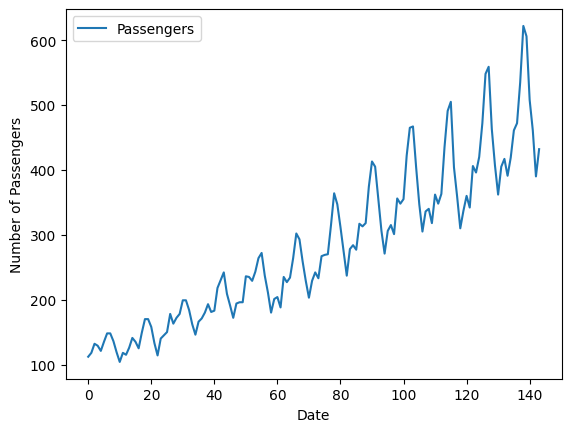

In [26]:
import pandas as pd
from matplotlib import pyplot as plt

# Plot the series with explicit label and legend enabled
series.plot()
plt.ylabel('Number of Passengers')
plt.xlabel('Date')
plt.show()

### 2.1 Model Evaluation

Model evaluation will only be performed on the data in dataset.csv. The observations are a count of champagne sales in millions of units. We will evaluate the performance of predictions using the root mean squared error (RMSE). This will give more weight to predictions that are grossly wrong and will have the same units as the original data.  

Any transforms to the data must be reversed before the RMSE is calculated and reported to make the performance between different methods directly comparable.
  
We can calculate the RMSE using the helper function from the scikit-learn library mean_squared_error() that calculates the mean squared error between a list of expected values (the test set) and the list of predictions. We can then take the square root of this value to give us an RMSE score.  

### 2.2 Walk-forward validation

Candidate models will be evaluated using walk-forward validation. This is because a rolling-forecast type model is required from the problem definition. This is where one-step forecasts are needed given all available data.

The walk-forward validation will work as follows:  

The first X% of the dataset will be held back to train the model. The remaining Y (=100-X)% of the dataset will be iterated and test the model. For each step in the test dataset: A model will be trained.  

A one-step prediction made and the prediction stored for later evaluation. The actual observation from the test dataset will be added to the training dataset for the next iteration.  The predictions made during the iteration of the test dataset will be evaluated and an RMSE score reported. Given the small size of the data, we will allow a model to be re-trained given all available data prior to each prediction.  

Firstly, we can split the dataset into train and test sets directly. We’re careful to always convert a loaded dataset to float32 in case the loaded data still has some String or Integer data types.  

In [29]:
X = series['Passengers'].values  # Extracting only the 'Passengers' column as a NumPy array
X = X.astype('float32')  # Ensuring all data is in float32 format

# Splitting the dataset into training and testing sets (50% split)
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# Output sizes to verify
print(f"Training data size: {train.shape}")
print(f"Testing data size: {test.shape}")

Training data size: (72,)
Testing data size: (72,)


### 2.3 Forecasting baseline

Next, we can iterate over the time steps in the test dataset. The train dataset is stored in a Python list as we need to easily append a new observation each iteration and NumPy array concatenation feels like overkill.

The prediction made by the model is called $\hat{y}$ or yhat (or $y_{model}$ equal to $X_{t}$ in above discussion) for convention, as the outcome or observation is referred to as y and $\hat{y}$ is the mathematical notation for the prediction of the y variable.

The prediction and observation are printed each observation for a sanity check prediction in case there are issues with the model. Let's use a very simple forecasting baseline, that the ***result is the same 1 step ago***.

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

>Predicted=229.000, Expected=242
>Predicted=242.000, Expected=233
>Predicted=233.000, Expected=267
>Predicted=267.000, Expected=269
>Predicted=269.000, Expected=270
>Predicted=270.000, Expected=315
>Predicted=315.000, Expected=364
>Predicted=364.000, Expected=347
>Predicted=347.000, Expected=312
>Predicted=312.000, Expected=274
>Predicted=274.000, Expected=237
>Predicted=237.000, Expected=278
>Predicted=278.000, Expected=284
>Predicted=284.000, Expected=277
>Predicted=277.000, Expected=317
>Predicted=317.000, Expected=313
>Predicted=313.000, Expected=318
>Predicted=318.000, Expected=374
>Predicted=374.000, Expected=413
>Predicted=413.000, Expected=405
>Predicted=405.000, Expected=355
>Predicted=355.000, Expected=306
>Predicted=306.000, Expected=271
>Predicted=271.000, Expected=306
>Predicted=306.000, Expected=315
>Predicted=315.000, Expected=301
>Predicted=301.000, Expected=356
>Predicted=356.000, Expected=348
>Predicted=348.000, Expected=355
>Predicted=355.000, Expected=422
>Predicted

The RMSE (**43**) or MAE (**36**) computed from 1 step time ahead is like the proportional chance criterion ratio for time series forecasting. You must beat the accuracy of prediction that assumes the next **"time step is just equal to the current time step"**.

### 2.4 Basic Statistics of the system

Running the example provides a number of summary statistics to review. Some observations from these statistics include:

The number of observations (count) matches our expectation, meaning we are handling the data correctly.
The mean is about 4,761, which we might consider our level in this series.
The standard deviation (average spread from the mean) is relatively large at 2,553 sales.
The percentiles along with the standard deviation do suggest a large spread to the data.

In [32]:
from pandas import read_csv

# Read the CSV file
series = read_csv(data_dir + 'dataset.csv', header=None, index_col=0, parse_dates=True)

# If the result is a single-column DataFrame, squeeze it to convert it into a Series
series = series.squeeze()

# Print descriptive statistics
print(series.describe())

                2
count  132.000000
mean   262.492424
std    106.625799
min    104.000000
25%    176.500000
50%    239.500000
75%    343.250000
max    559.000000


In [35]:
series

,1,2
0,,
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
...,...,...
127,1959-08,559.0
128,1959-09,463.0
129,1959-10,407.0


Note that the MAE of **36** in the previous walk in validation step is lower than the standard deviation implying that such a simple rule is giving sensible a prediction.

### 2.5 Seasonal Line Plots

We can confirm the assumption that the seasonality is a yearly cycle by eyeballing line plots of the dataset by year.  

The example below takes the 7 full years of data as separate groups and creates one line plot for each. The line plots are aligned vertically to help spot any year-to-year pattern.  

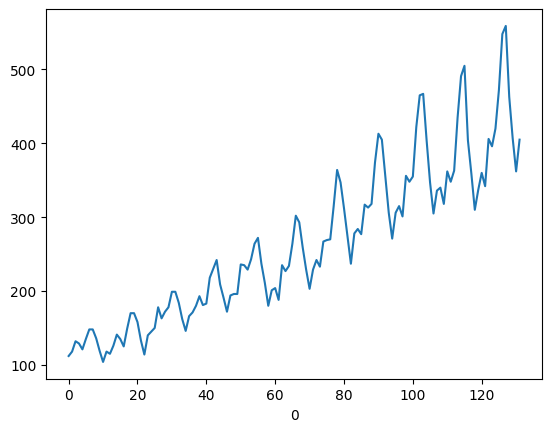

In [34]:
from pandas import read_csv
from matplotlib import pyplot as plt
# For Jupyter notebooks
%matplotlib inline

# Read the CSV file
series = read_csv(data_dir + 'dataset.csv', header=None, index_col=0, parse_dates=True)

# Squeeze the result if it's a single-column DataFrame
series = series.squeeze()

# Plot the series
series.plot(legend=False)

# Show the plot
plt.show()


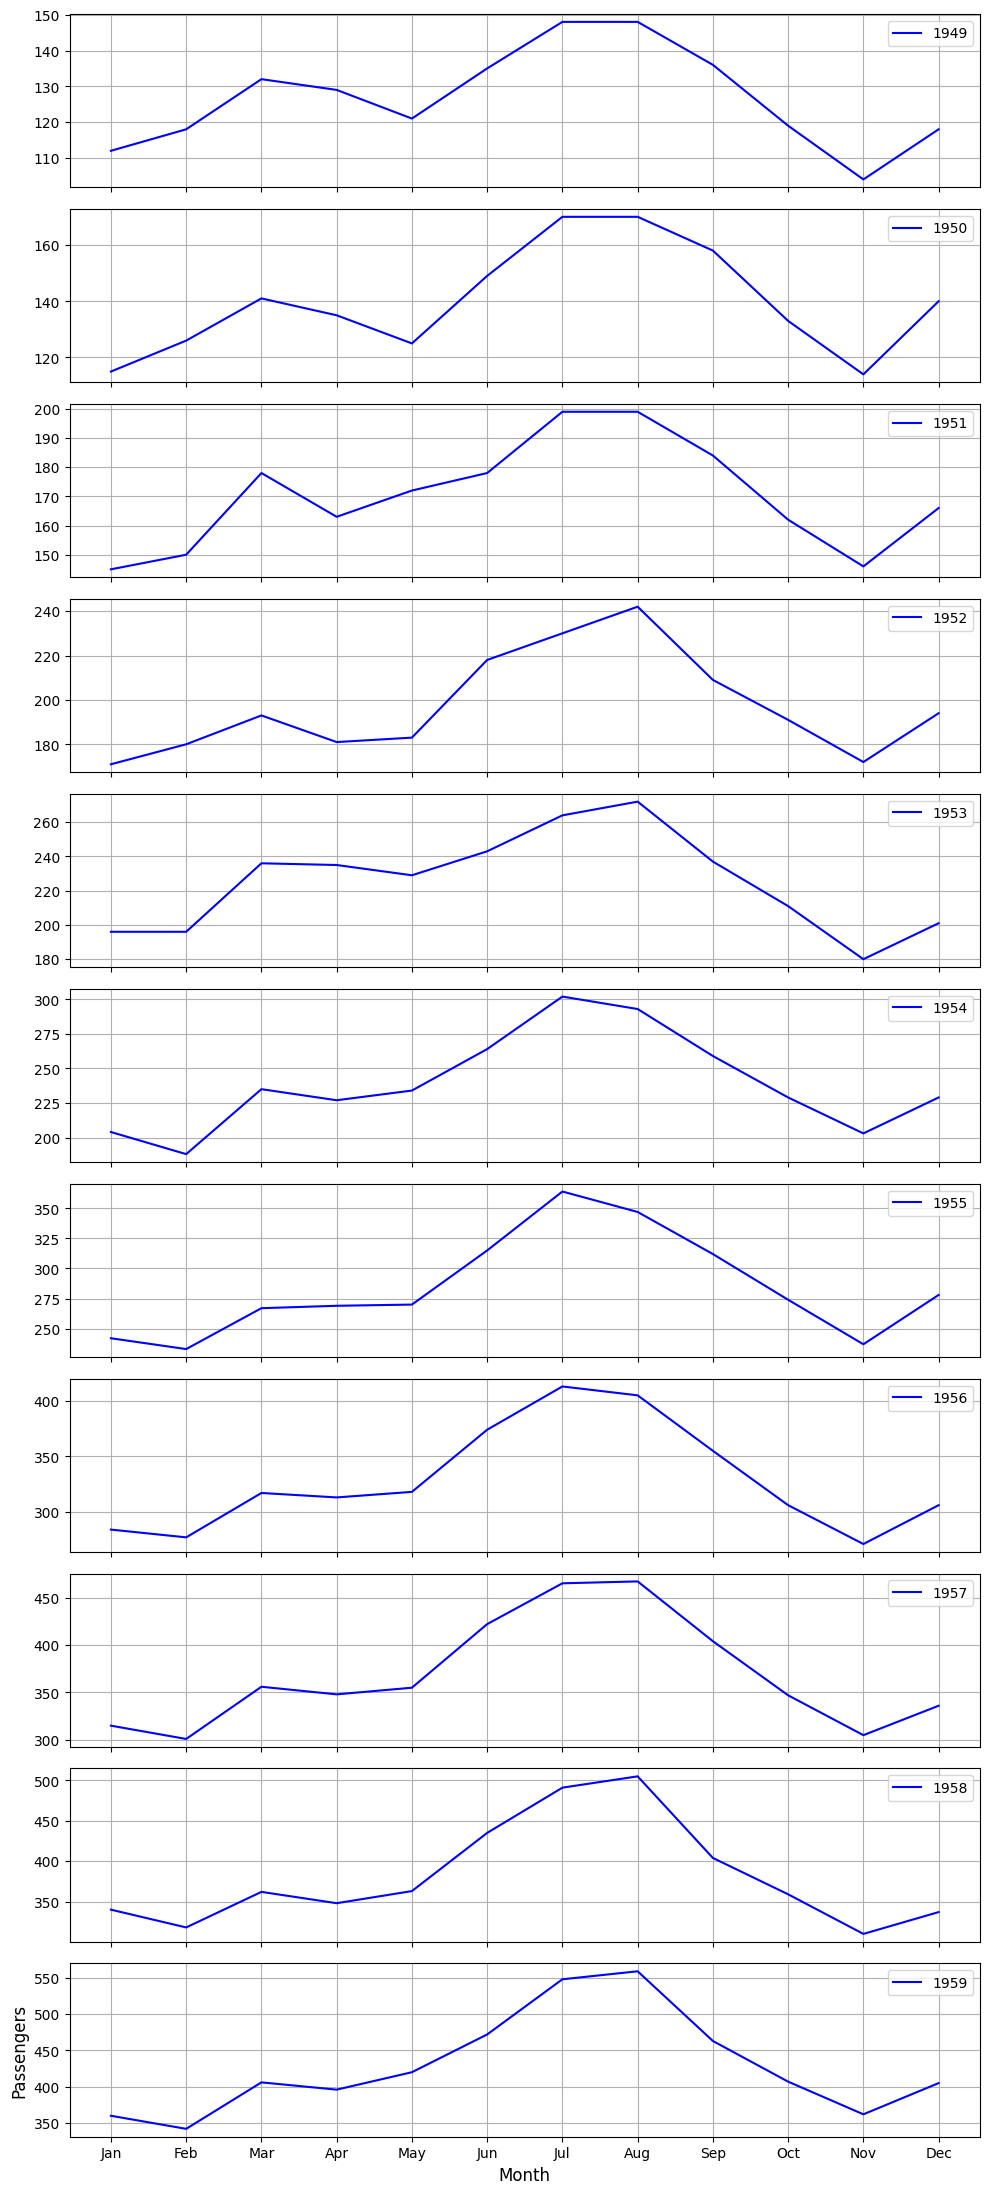

In [52]:
import pandas as pd
from matplotlib import pyplot as plt

# Load the dataset correctly, using the second column (dates) as the index and the third column as the passenger values
series = pd.read_csv(data_dir + 'dataset.csv', header=None, usecols=[1, 2], index_col=0, parse_dates=True)

# Rename the column for clarity
series.columns = ['Passengers']

# Group the data by year and month
groups = series.groupby(series.index.year)

# Initialize the plotting area, one subplot per year
fig, axs = plt.subplots(len(groups), 1, figsize=(10, len(groups) * 2), sharex=True)

# If there's only one subplot, axs will not be a list, so we need to ensure it's iterable
if len(groups) == 1:
    axs = [axs]

# Loop over each year to plot separately
for i, (year, group) in enumerate(groups):
    # Plot the monthly values for the current year
    axs[i].plot(group.index.month, group['Passengers'], label=f'{year}', color='b')
    axs[i].set_xticks(range(1, 13))  # Set x-axis ticks for 12 months
    axs[i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axs[i].legend(loc='upper right')  # Display year in the legend
    axs[i].grid(True)  # Add grid for clarity

# Set a common x-axis and y-axis label
plt.xlabel('Month', fontsize=12)
plt.ylabel('Passengers', fontsize=12)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

Running the example creates the stack of 7 line plots. We can clearly see a dip each August and a rise from each August to December. This pattern appears the same each year, although at different levels.

This will help with any explicitly season-based modeling later.

### 2.6 Density Plot

Reviewing plots of the density of observations can provide further insight into the structure of the data. The example below creates a histogram and density plot of the observations without any temporal structure.

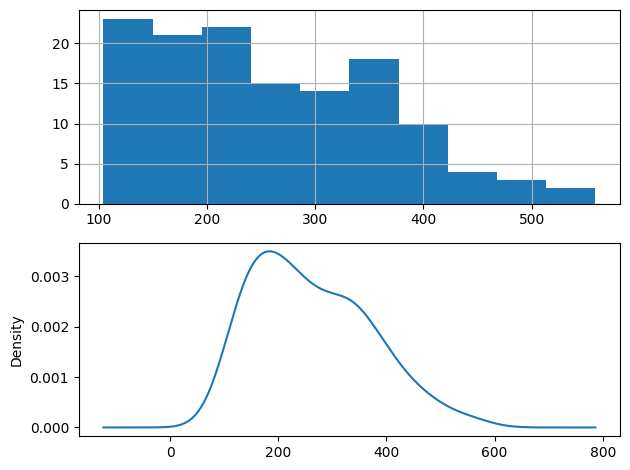

In [55]:
import pandas as pd
from matplotlib import pyplot as plt

# Load the dataset, using the second column (dates) as the index and the third column as the passenger values
series = pd.read_csv(data_dir + 'dataset.csv', header=None, usecols=[1, 2], index_col=0, parse_dates=True).squeeze()

# Create the figure for subplots
plt.figure(1)

# Create the histogram in the first subplot
plt.subplot(211)
series.hist()

# Create the kernel density estimate (KDE) plot in the second subplot
plt.subplot(212)
series.plot(kind='kde')

# Show the plot
plt.tight_layout()  # Ensures that the subplots don't overlap
plt.show()

Some observations from the plots include:

--- The distribution is not Gaussian.

--- The shape has a long right tail and may suggest an exponential distribution.This lends more support to exploring some power transforms of the data prior to modeling.

### 2.7 Box and Whisker Plots

We can group the monthly data by year and get an idea of the spread of observations for each year and how this may be changing.  

We do expect to see some trend (increasing mean or median), but it may be interesting to see how the rest of the distribution may be changing.  

The example below groups the observations by year and creates one box and whisker plot for each year of observations. The last year (1971) only contains 9 months and may not be a useful comparison with the 12 months of observations for other years. Therefore, only data between 1964 and 1970 was plotted.  

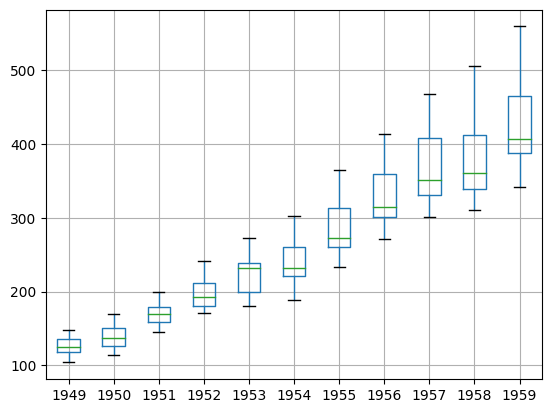

In [57]:
import pandas as pd
from matplotlib import pyplot as plt

# Load the dataset, using the second column (dates) as the index and the third column as the passenger values
series = pd.read_csv(data_dir + 'dataset.csv', header=None, usecols=[1, 2], index_col=0, parse_dates=True).squeeze()

# Group the series data by year ('A' stands for annual frequency)
groups = series['1949':'1959'].groupby(pd.Grouper(freq='A'))

# Create an empty DataFrame to store yearly data
years = pd.DataFrame()

# Loop through each group and store the values in the 'years' DataFrame
for name, group in groups:
    years[name.year] = group.values

# Plot a boxplot for each year
years.boxplot()

# Show the plot
plt.show()

Running the example creates 7 box and whisker plots side-by-side, one for each of the 7 years of selected data.

Some observations from reviewing the plots include:  

The median values for each year (green line) may show an increasing trend.  
The spread or middle 50% of the data (blue boxes) does appear reasonably stable.  
There are outliers each year (black crosses); these may be the tops or bottoms of the seasonal cycle.  
The last year, 1970, does look different from the trend in prior years  

The observations suggest perhaps some growth trend over the years and outliers that may be a part of the seasonal cycle.  

This yearly view of the data is an interesting avenue and could be pursued further by looking at summary statistics from year-to-year and changes in summary stats from year-to-year.  

# 3. ARIMA Models

This section will implement the ARIMA models for the  (Time Series of Champagne.csv). We will look at the impact of the different hyper-tuning parameters and their corresponding significance on the nature of the time series. We will also discuss how the prediction's accuracy can be further improved based on the statistical distribution of the residual errors of the model selected.

### 3.1 Let's manually configure ARIMA!

The ARIMA(p,d,q) model requires three parameters and is traditionally configured manually.  Analysis of the time series data assumes that we are working with a stationary time series.  Time series is almost certainly non-stationary. We can make it stationary this by first differencing the series and using a statistical test to confirm that the result is stationary.  

The seasonality in the series is seemingly year-to-year. Seasonal data can be differenced by subtracting the observation from the same time in the previous cycle, in this case the same month in the previous year. This does mean that we will lose the first year of observations as there is no prior year to difference with.  

The example below creates a deseasonalized version of the series and saves it to file stationary.csv.  

ADF Statistic: -3.048011
p-value: 0.030648
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


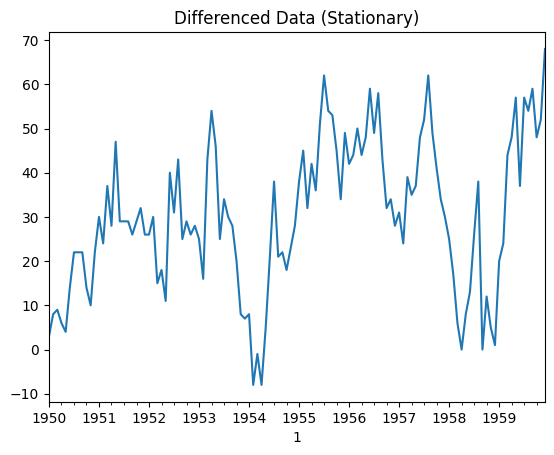

In [59]:
from pandas import read_csv, Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt

# Function to create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# Load the dataset, using the second column (dates) as the index and the third column as the passenger values
series = read_csv(data_dir + 'dataset.csv', header=None, usecols=[1, 2], index_col=0, parse_dates=True).squeeze()

# Convert the series values to float32
X = series.values
X = X.astype('float32')

# Difference the data with a 12-month (1 year) interval
months_in_year = 12
stationary = difference(X, months_in_year)

# Set the index of the stationary series to align with the original series
stationary.index = series.index[months_in_year:]

# Perform the ADF (Augmented Dickey-Fuller) test to check for stationarity
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Save the differenced data to a CSV file
stationary.to_csv(data_dir + 'stationary.csv', header=False)

# Plot the differenced data
stationary.plot()
plt.title('Differenced Data (Stationary)')
plt.show()

### Stationarity is critical and we need to run statistics

Running the example outputs the result of a statistical significance test of whether the differenced series is stationary. Specifically, the augmented Dickey-Fuller test. Null hypothesis is the system has unit root which implies, it is non-stationary. Rejection of null hypothesis means that the process has no unit root, and in turn that the time series is stationary.  

The results show that the test statistic value -7.134898 is smaller than the critical value at 1% of -3.515. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).  Rejecting the null hypothesis means that the process has no unit root, and in turn that **the time series is stationary or does not have time-dependent structure**.

Notice that if we did not do a 12 month differencing and simply use the series the results would be non-stationary.

In [60]:
# check if stationary
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#p < \alpha reject the null hypothesis (system has no unit root = stationary)
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save


ADF Statistic: 0.888027
p-value: 0.992932
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


For reference, the seasonal difference operation can be inverted by adding the observation for the same month the year before. This is needed in the case that predictions are made by a model fit on seasonally differenced data. The function to invert the seasonal difference operation is listed below for completeness.



In [61]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

A plot of the differenced dataset is also created. The plot does not show any obvious seasonality or trend, suggesting the seasonally differenced dataset is a good starting point for modeling. We will use this dataset as an input to the ARIMA model. It also suggests that no further differencing may be required, and that **the d parameter may be set to 0.**

The next first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

Note, we are now using the seasonally differenced stationary.csv as our dataset. The example below creates ACF and PACF plots for the series.

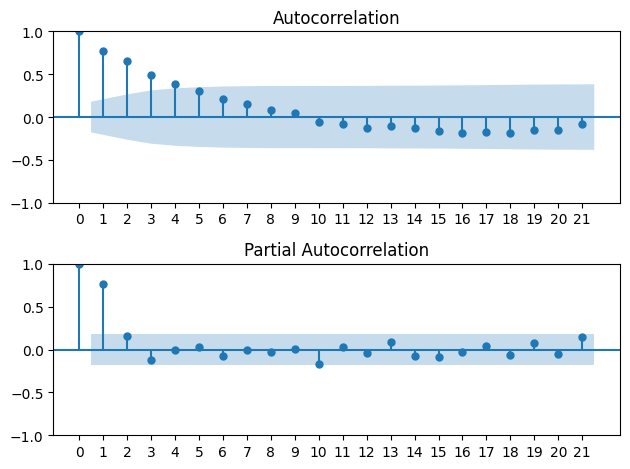

In [69]:
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt

# Load the dataset
series = read_csv(data_dir + 'stationary.csv', header=None, index_col=0, parse_dates=True).squeeze()

# Create a figure for subplots
plt.figure()

# Plot ACF (Autocorrelation Function) in the first subplot
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.xticks(range(0, 22, 1))  # Set x-axis ticks with interval of 1

# Plot PACF (Partial Autocorrelation Function) in the second subplot
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.xticks(range(0, 22, 1))  # Set x-axis ticks with interval of 1

# Show the plots
plt.tight_layout()  # Ensure no overlapping between plots
plt.show()

Run the example and review the plots for insights into how to set the p and q variables for the ARIMA model.

Below are some observations from the plots.

The ACF shows a significant lag for 1 month.
The PACF shows a significant lag for 1 month, with perhaps some significant lag at 12 and 13 months.
Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of AR and MA.
A good starting point for the p and q values is also 1.

The PACF plot also suggests that there is still some seasonality present in the differenced data.

We may consider a better model of seasonality, such as modeling it directly and explicitly removing it from the model rather than seasonal differencing.

This quick analysis suggests an ARIMA(1,0,1) on the stationary data may be a good starting point.

The historic observations will be seasonally differenced prior to the fitting of each ARIMA model. The differencing will be inverted for all predictions made to make them directly comparable to the expected observation in the original sale count units.

Experimentation shows that this configuration of ARIMA does not converge and results in errors by the underlying library. Further experimentation showed that adding one level of differencing to the stationary data made the model more stable. The model can be extended to ARIMA(1,1,1).

We will also disable the automatic addition of a trend constant from the model by setting the ‘trend‘ argument to ‘nc‘ for no constant in the call to fit(). From experimentation, I find that this can result in better forecast performance on some problems.

The example below demonstrates the performance of this ARIMA model on the test harness.

In [73]:
from pandas import read_csv
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

# Create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# Invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# Load the dataset
series = read_csv(data_dir + 'stationary.csv', header=None)

# Extract only the numeric values (ignore the first column if it's a date or index)
X = series.iloc[:, 1].values  # Assuming passenger data is in the second column

# Ensure the values are float type
X = X.astype('float32')

# Split into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]

# Walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    # Difference the data
    months_in_year = 12
    diff = difference(history, months_in_year)

    # Fit ARIMA model (you can adjust the order as needed)
    model = ARIMA(diff, order=(0, 0, 0))
    model_fit = model.fit()

    # Forecast one step ahead
    forecast = model_fit.get_forecast(steps=1)
    yhat = forecast.predicted_mean[0]

    # Reverse the differencing to obtain the original scale
    yhat = inverse_difference(history, yhat, months_in_year)

    # Append the forecasted value to the predictions list
    predictions.append(yhat)

    # Observation (actual value from test set)
    obs = test[i]
    history.append(obs)

    # Print predicted vs expected
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# Report performance metrics
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)

>Predicted=34.881, Expected= 25
>Predicted=27.765, Expected= 17
>Predicted=42.640, Expected=  6
>Predicted=38.218, Expected=  0
>Predicted=39.784, Expected=  8
>Predicted=50.427, Expected= 13
>Predicted=54.011, Expected= 26
>Predicted=63.703, Expected= 38
>Predicted=50.424, Expected=  0
>Predicted=41.882, Expected= 12
>Predicted=34.564, Expected=  5
>Predicted=30.253, Expected=  1
>Predicted=24.948, Expected= 20
>Predicted=16.897, Expected= 24
>Predicted=5.969, Expected= 44
>Predicted=0.354, Expected= 48
>Predicted=8.830, Expected= 57
>Predicted=14.307, Expected= 37
>Predicted=27.529, Expected= 57
>Predicted=39.816, Expected= 54
>Predicted=1.952, Expected= 59
>Predicted=14.495, Expected= 48
>Predicted=7.811, Expected= 52
>Predicted=4.224, Expected= 68
RMSE: 35.433
MAE: 32.013


Note, you may see a warning message from the underlying linear algebra library; this can be ignored for now.

Running this example results in an RMSE and MAE of 1013.464 and 825.016, respectively, which is dramatically better than the 1 step walkin RMSE and MAE of 3167.362 and 2100.830, respectively.

This is a great start, but we may be able to get improved results with a better configured ARIMA model.

### 3.2 Automatically configure ARIMA: Grid Search ARIMA Hyperparameters

The ACF and PACF plots suggest that an ARIMA(1,0,1) or similar may be the best that we can do.

To confirm this analysis, we can grid search a suite of ARIMA hyperparameters and check that no models result in better out of sample RMSE performance.

In this section, we will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance on the test set. We will use a grid search to explore all combinations in a subset of integer values.

Specifically, we will search all combinations of the following parameters:

p: 0 to 6.
d: 0 to 2.
q: 0 to 6.
This is (7 * 3 * 7), or 147, potential runs of the test harness and will take some time to execute.

It may be interesting to evaluate MA models with a lag of 12 or 13 as were noticed as potentially interesting from reviewing the ACF and PACF plots. Experimentation suggested that these models may not be stable, resulting in errors in the underlying mathematical libraries.

The complete worked example with the grid search version of the test harness is listed below.

In [74]:
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA

# Create a differenced series
def difference(dataset, interval=1):
    diff = np.diff(dataset, n=interval)
    return diff

# Invert differenced value
#def inverse_difference(history, yhat, interval=1):
#    return yhat + history[-interval]

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# Evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    #X = X.astype('float32')
    train_size = int(len(X) * 0.80)  # Use 80% of data for training
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    #history = list(train)
    months_in_year = 12  # Define the number of months in a year

    # Make predictions
    predictions = list()
    for t in range(len(test)):
        # Difference data
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=1)
        yhat = forecast.predicted_mean[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)

    # Calculate out-of-sample error (RMSE)
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    #print(test)
    #print(predictions)
    return rmse


In [76]:
# Extract only the numeric values (assuming numeric data is in the second column)
X = series.iloc[:, 1].astype('float32').values

# Evaluate the ARIMA model with order (p, d, q) = (0, 0, 1)
rmse = evaluate_arima_model(X, (0, 0, 1))

# Print the result
print(f'RMSE for ARIMA(0, 0, 1): {rmse:.3f}')

RMSE for ARIMA(0, 0, 1): 16.035


In [77]:
from itertools import product
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Filter out ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

# Define ranges for p, d, q
p_range = range(0, 4)
d_range = range(0, 2)
q_range = range(0, 4)

# Initialize a dictionary to store the results
results = {}

# Iterate over all combinations of p, d, q
for p, d, q in product(p_range, d_range, q_range):
    order = (p, d, q)
    # Evaluate the ARIMA model for the current (p, d, q) order
    rmse = evaluate_arima_model(X, order)
    # Store the result in the dictionary
    results[order] = rmse
    print(f"Order {order}, RMSE: {rmse}")

# Find the (p, d, q) combination with the lowest RMSE
best_order = min(results, key=results.get)
best_rmse = results[best_order]

# Print the best (p, d, q) combination and the corresponding RMSE
print(f"\nBest Order: {best_order}, Lowest RMSE: {best_rmse}")



Order (0, 0, 0), RMSE: 20.441192894528257
Order (0, 0, 1), RMSE: 16.034744476016826
Order (0, 0, 2), RMSE: 14.146867838540118
Order (0, 0, 3), RMSE: 12.892284134518631
Order (0, 1, 0), RMSE: 12.954335753515686
Order (0, 1, 1), RMSE: 12.940213947477577
Order (0, 1, 2), RMSE: 13.074519360242423
Order (0, 1, 3), RMSE: 12.957654463588838
Order (1, 0, 0), RMSE: 12.643366318299362
Order (1, 0, 1), RMSE: 12.66167886142016
Order (1, 0, 2), RMSE: 12.477491251563377
Order (1, 0, 3), RMSE: 12.65772290717672
Order (1, 1, 0), RMSE: 12.815013902416059
Order (1, 1, 1), RMSE: 12.776372244034537
Order (1, 1, 2), RMSE: 12.880965423013627
Order (1, 1, 3), RMSE: 13.105949287749658
Order (2, 0, 0), RMSE: 12.624857963845947
Order (2, 0, 1), RMSE: 12.741297792650457
Order (2, 0, 2), RMSE: 12.537240536946024
Order (2, 0, 3), RMSE: 12.659735231530133
Order (2, 1, 0), RMSE: 12.848654201715187
Order (2, 1, 1), RMSE: 12.865468699861676
Order (2, 1, 2), RMSE: 12.73563322110768
Order (2, 1, 3), RMSE: 13.29058059690

Running the example runs through all combinations and reports the results on those that converge without error. The results show that the best configuration discovered was ARIMA(1, 1, 0) with an RMSE of 910.72, lower than the manually configured ARIMA from the previous section.

### 3.3 Review Residual Errors

A good final check of a model is to review residual forecast errors.

Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

We can check this by using summary statistics and plots to investigate the residual errors from the ARIMA(0, 0, 1) model. The example below calculates and summarizes the residual forecast errors.


               0
count  27.000000
mean    0.566952
std    13.046345
min   -35.772954
25%    -8.738336
50%     1.906298
75%     9.258751
max    20.928967


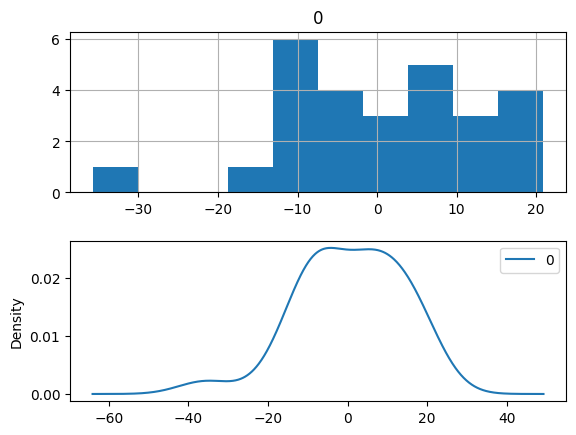

In [79]:
from pandas import read_csv
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = dataset
# prepare data
X = series.values
X = series.iloc[:, 1].astype('float32').values
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,1,0))
	model_fit = model.fit()
	forecast = model_fit.get_forecast(steps=1)
	#Get the forecasted value
	yhat = forecast.predicted_mean[0]
	#Reverse the differencing if necessary (assuming you have the inverse_difference function)
	yhat = inverse_difference(history, yhat, months_in_year)
  #Append the forecasted value to the predictions list
	predictions.append(yhat)

	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

Running the example first describes the distribution of the residuals. We can see that the distribution has a right shift and that the **mean is non-zero at 124.187913.**

This is perhaps a sign that the predictions are biased. The distribution of residual errors is also plotted. The graphs suggest a Gaussian-like distribution with a bumpy left tail, providing further evidence that perhaps a power transform might be worth exploring.

We could use this information to bias-correct predictions by adding the mean residual error of 124.187913to each forecast made.

The example below performs this bias correlation.

RMSE: 12.802
                  0
count  2.700000e+01
mean   2.511987e-07
std    1.304634e+01
min   -3.633991e+01
25%   -9.305288e+00
50%    1.339346e+00
75%    8.691799e+00
max    2.036201e+01


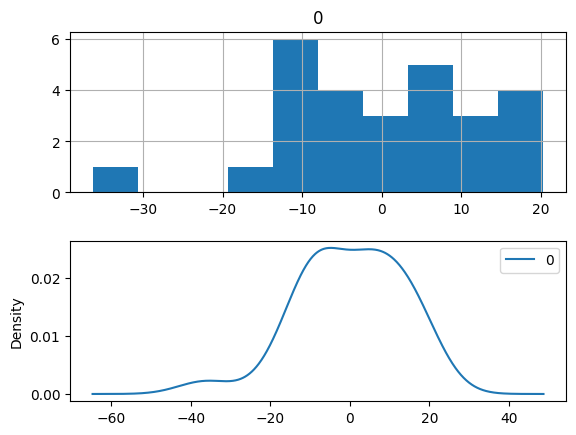

In [80]:
from pandas import read_csv
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = dataset
# prepare data
X = series.values
X = series.iloc[:, 1].astype('float32').values
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 0.566952

for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,1,0))
	model_fit = model.fit()
	forecast = model_fit.get_forecast(steps=1)
	#Get the forecasted value
	yhat = forecast.predicted_mean[0]
	#Reverse the differencing if necessary (assuming you have the inverse_difference function)
	yhat = bias+inverse_difference(history, yhat, months_in_year)
  #Append the forecasted value to the predictions list
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

It is also a good idea to check the time series of the residual errors for any type of autocorrelation. If present, it would suggest that the model has more opportunity to model the temporal structure in the data.

The example below re-calculates the residual errors and creates ACF and PACF plots to check for any significant autocorrelation.

The results suggest that what little autocorrelation is present in the time series has been captured by the model.

In [81]:
import pickle
from statsmodels.tsa.arima.model import ARIMA
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# load data
series = dataset
# prepare data
X = series.values
X = series.iloc[:, 1].astype('float32').values
# difference data
months_in_year = 12
diff = difference(X, months_in_year)


# Define a custom method to handle the serialization issue
def custom_arima_getnewargs(self):
    # Replace 'self.endog' with the appropriate attribute if needed
    # You might need to adjust this depending on your ARIMA model's configuration
    return (self.endog, self.order)

# Monkey patch the ARIMA class
ARIMA.__getnewargs__ = custom_arima_getnewargs

# Example: ARIMA model training
# Replace with your actual time series data and ARIMA configuration
model = ARIMA(X, order=(1, 1, 0))
model_fit = model.fit()

# Save
with open(data_dir +'arima_model.pkl', 'wb') as pkl:
    pickle.dump(model_fit, pkl)

### 3.4 Make Prediction and Validate the model

A natural case may be to load the model and make a single forecast.

This is relatively straightforward and involves restoring the saved model and the bias and calling the forecast() method. To invert the seasonal differencing, the historical data must also be loaded.

The example below loads the model, makes a prediction for the next time step, and prints the prediction.

We can load the model and use it in a pretend operational manner.

In the test harness section, we saved the final 12 months of the original dataset in a separate file to validate the final model.

We can load this validation.csv file now and use it see how well our model really is on “unseen” data.

There are two ways we might proceed:

Load the model and use it to forecast the next 12 months. The forecast beyond the first one or two months will quickly start to degrade in skill.
Load the model and use it in a rolling-forecast manner, updating the transform and model for each time step. This is the preferred method as it is how one would use this model in practice as it would achieve the best performance.
As with model evaluation in previous sections, we will make predictions in a rolling-forecast manner. This means that we will step over lead times in the validation dataset and take the observations as an update to the history.

>Predicted=901.710, Expected=112.000
>Predicted=393.807, Expected=118.000
>Predicted=302.847, Expected=132.000
>Predicted=253.635, Expected=129.000
>Predicted=276.147, Expected=121.000
>Predicted=302.007, Expected=135.000
>Predicted=340.472, Expected=148.000
>Predicted=290.585, Expected=148.000
>Predicted=177.377, Expected=136.000
>Predicted=194.497, Expected=119.000
>Predicted=194.903, Expected=104.000
>Predicted=268.954, Expected=118.000
>Predicted=-48.478, Expected=115.000
>Predicted=204.074, Expected=126.000
>Predicted=263.784, Expected=141.000
>Predicted=262.107, Expected=135.000
>Predicted=251.430, Expected=125.000
>Predicted=263.349, Expected=149.000
>Predicted=285.379, Expected=170.000
>Predicted=293.544, Expected=170.000
>Predicted=282.188, Expected=158.000
>Predicted=265.188, Expected=133.000
>Predicted=242.832, Expected=114.000
>Predicted=252.509, Expected=140.000
>Predicted=260.222, Expected=145.000
>Predicted=279.548, Expected=150.000
>Predicted=289.669, Expected=178.000
>

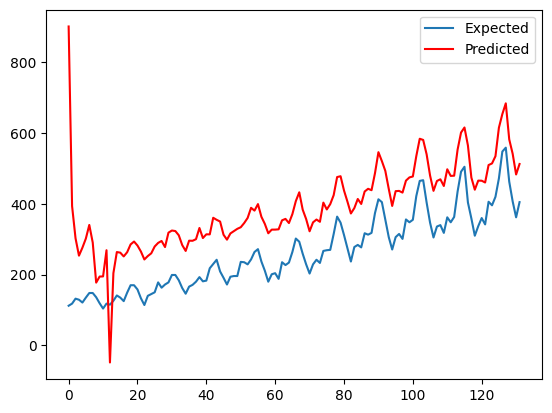

In [83]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import pickle  # Import pickle for loading the ARIMA model

# Create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# Invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# Load and prepare datasets
series = read_csv(data_dir + 'dataset.csv', header=None, index_col=0, parse_dates=True).squeeze()
X = series.iloc[:, 1].astype('float32').values
history = [x for x in X]
months_in_year = 12

# Load validation data
validation = read_csv(data_dir + 'validation.csv', header=None, index_col=0, parse_dates=True).squeeze()
y = series.iloc[:, 1].astype('float32').values

# Load the pre-trained ARIMA model using pickle
with open(data_dir + 'arima_model.pkl', 'rb') as pkl:
    model_fit = pickle.load(pkl)

# Set bias value (from earlier training)
bias = 124.187913

# Make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))

# Rolling forecasts
for i in range(1, len(y)):
    # Difference the data
    diff = difference(history, months_in_year)
    # Fit the ARIMA model
    model = ARIMA(diff, order=(1,1,0))
    model_fit = model.fit()
    # Forecast
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# Report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

# Plot expected vs predicted values
pyplot.plot(y, label='Expected')
pyplot.plot(predictions, color='red', label='Predicted')
pyplot.legend()
pyplot.show()


In [84]:
import numpy as np
from sklearn.metrics import r2_score

print("R2 score = %f"%r2_score( y,predictions))

R2 score = -0.841262
